# Diversified vs. Tech Portfolio Analysis

## Project Setup

This notebook requires several Python libraries. They can be installed via:
```bash
pip install -r requirements.txt
```
Helper functions are imported from 'utils.py'

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import os

from utils import get_data, quarterly_rebalancing


plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
%config InlineBackend.figure_format = 'retina'

In [2]:
tickers = ['XLK', 'SPY', 'XLF', 'XLE', 'XLV', 'XLI', 'XLP', 'XLU']
prices_df = get_data(tickers)
prices_df.head()

Loading data from local file...


,SPY,XLE,XLF,XLI,XLK,XLP,XLU,XLV
Date,,,,,,,,
2014-01-02,149.840530,56.203926,14.236197,41.767387,30.573997,31.333782,25.677317,45.763630
2014-01-03,149.815994,55.997787,14.334420,41.880863,30.427132,31.274738,25.594910,45.871532
2014-01-06,149.381851,56.075111,14.347518,41.637684,30.375305,31.156631,25.636116,45.680614
2014-01-07,150.299271,56.500244,14.354069,41.897072,30.651747,31.326403,25.862732,46.162067
2014-01-08,150.332031,56.107292,14.399901,41.824120,30.651747,31.090199,25.725388,46.568813


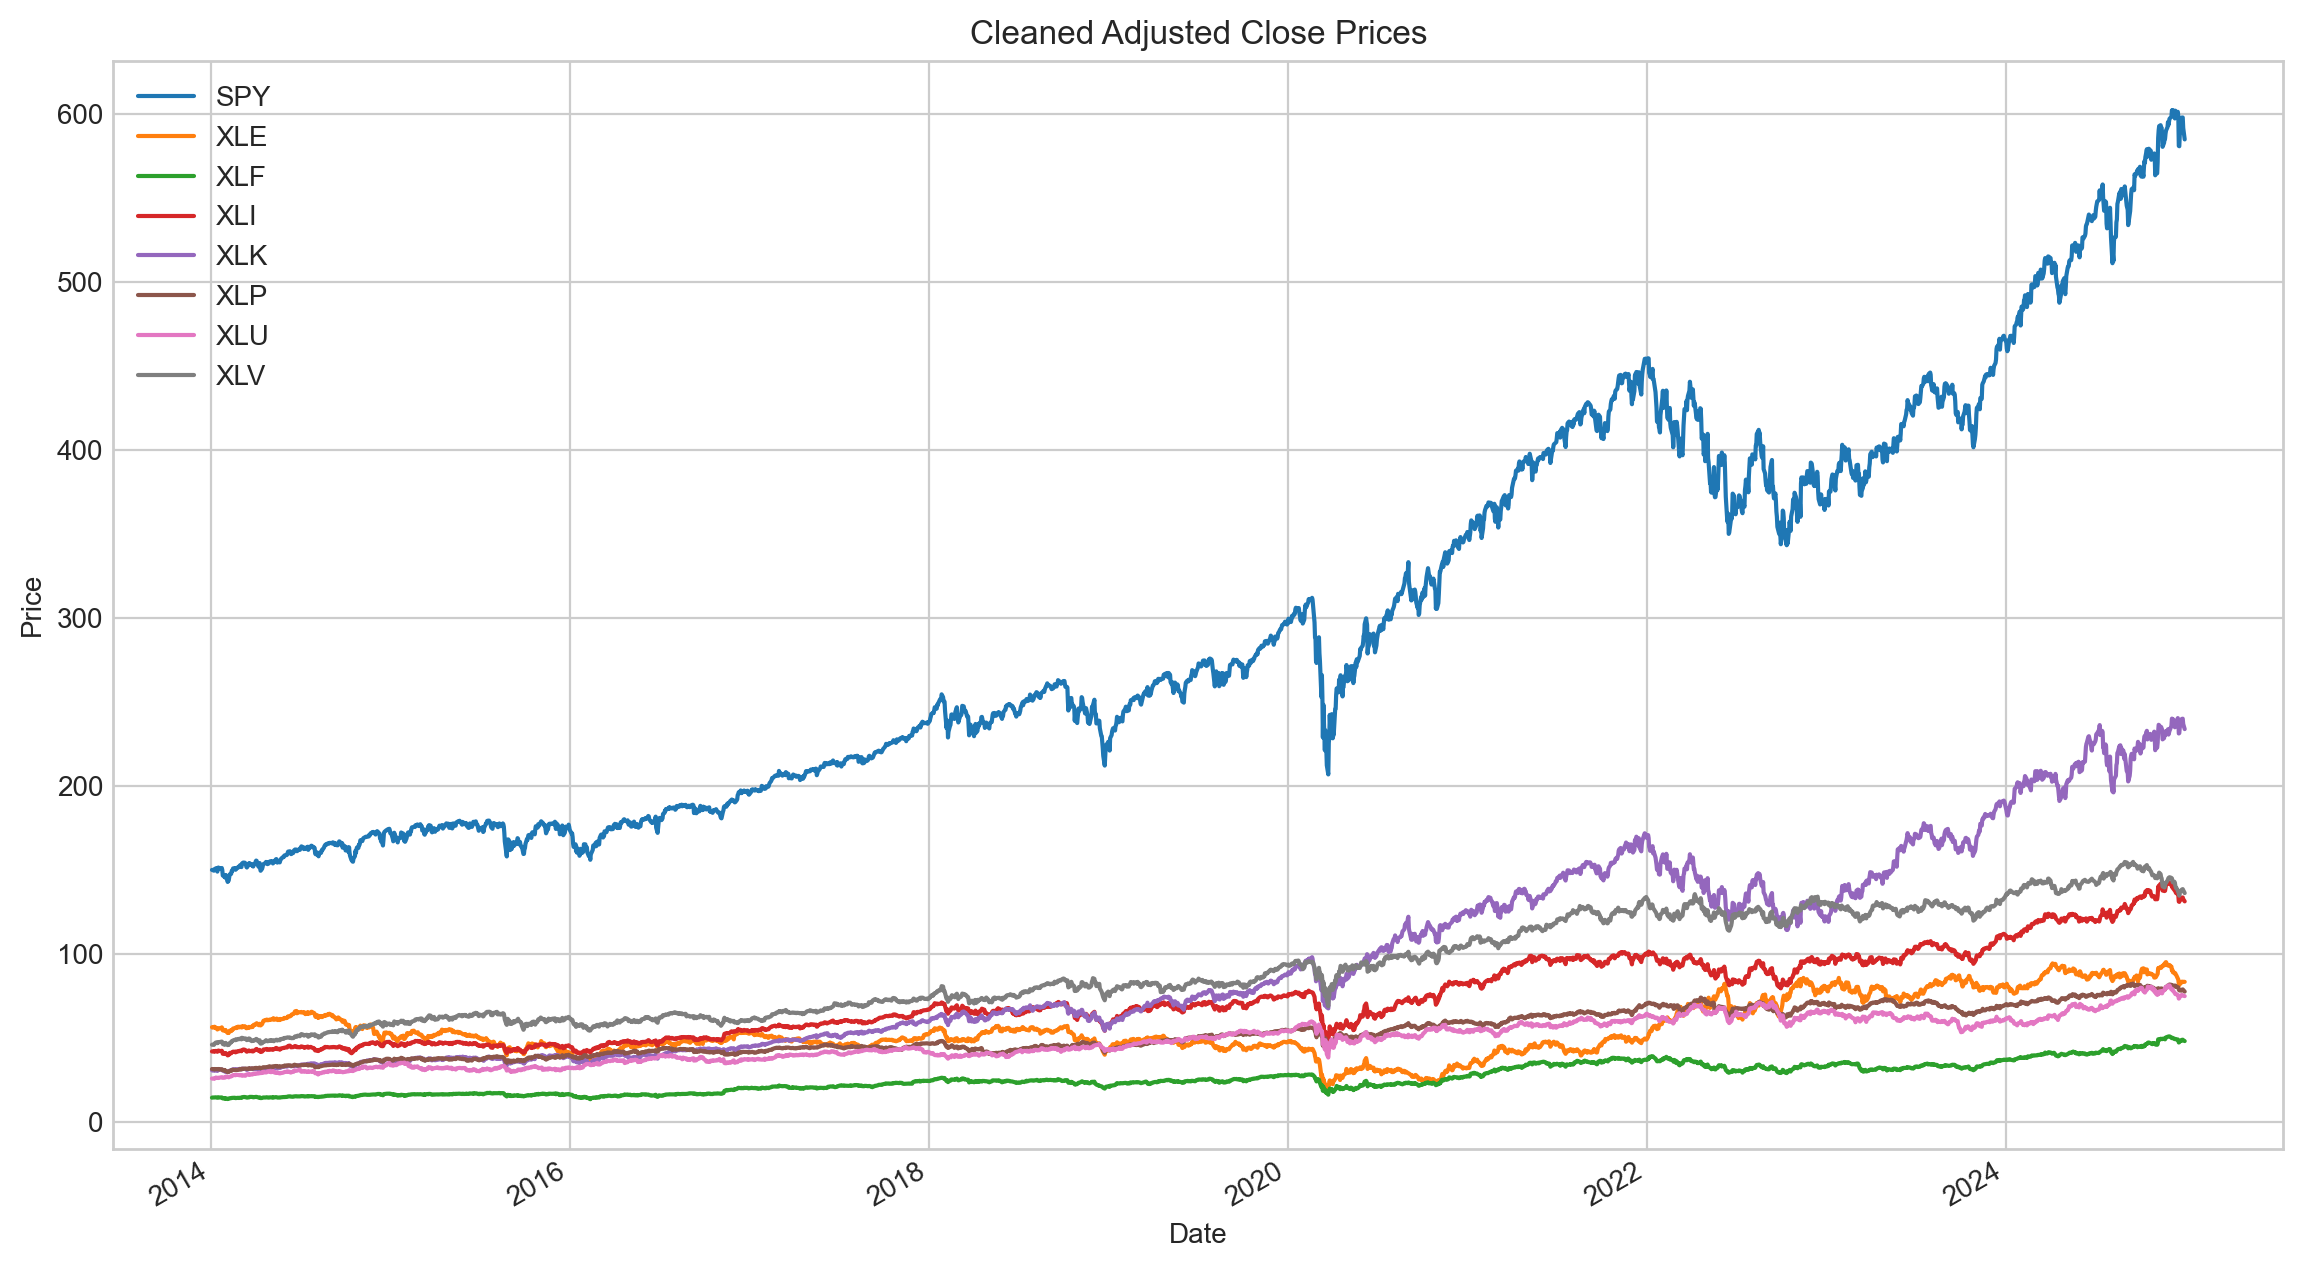

In [3]:
#Plot the data quickly to check for any outstanding issues:
prices_df.plot(title = 'Cleaned Adjusted Close Prices', figsize = (14, 8))
plt.ylabel('Price');

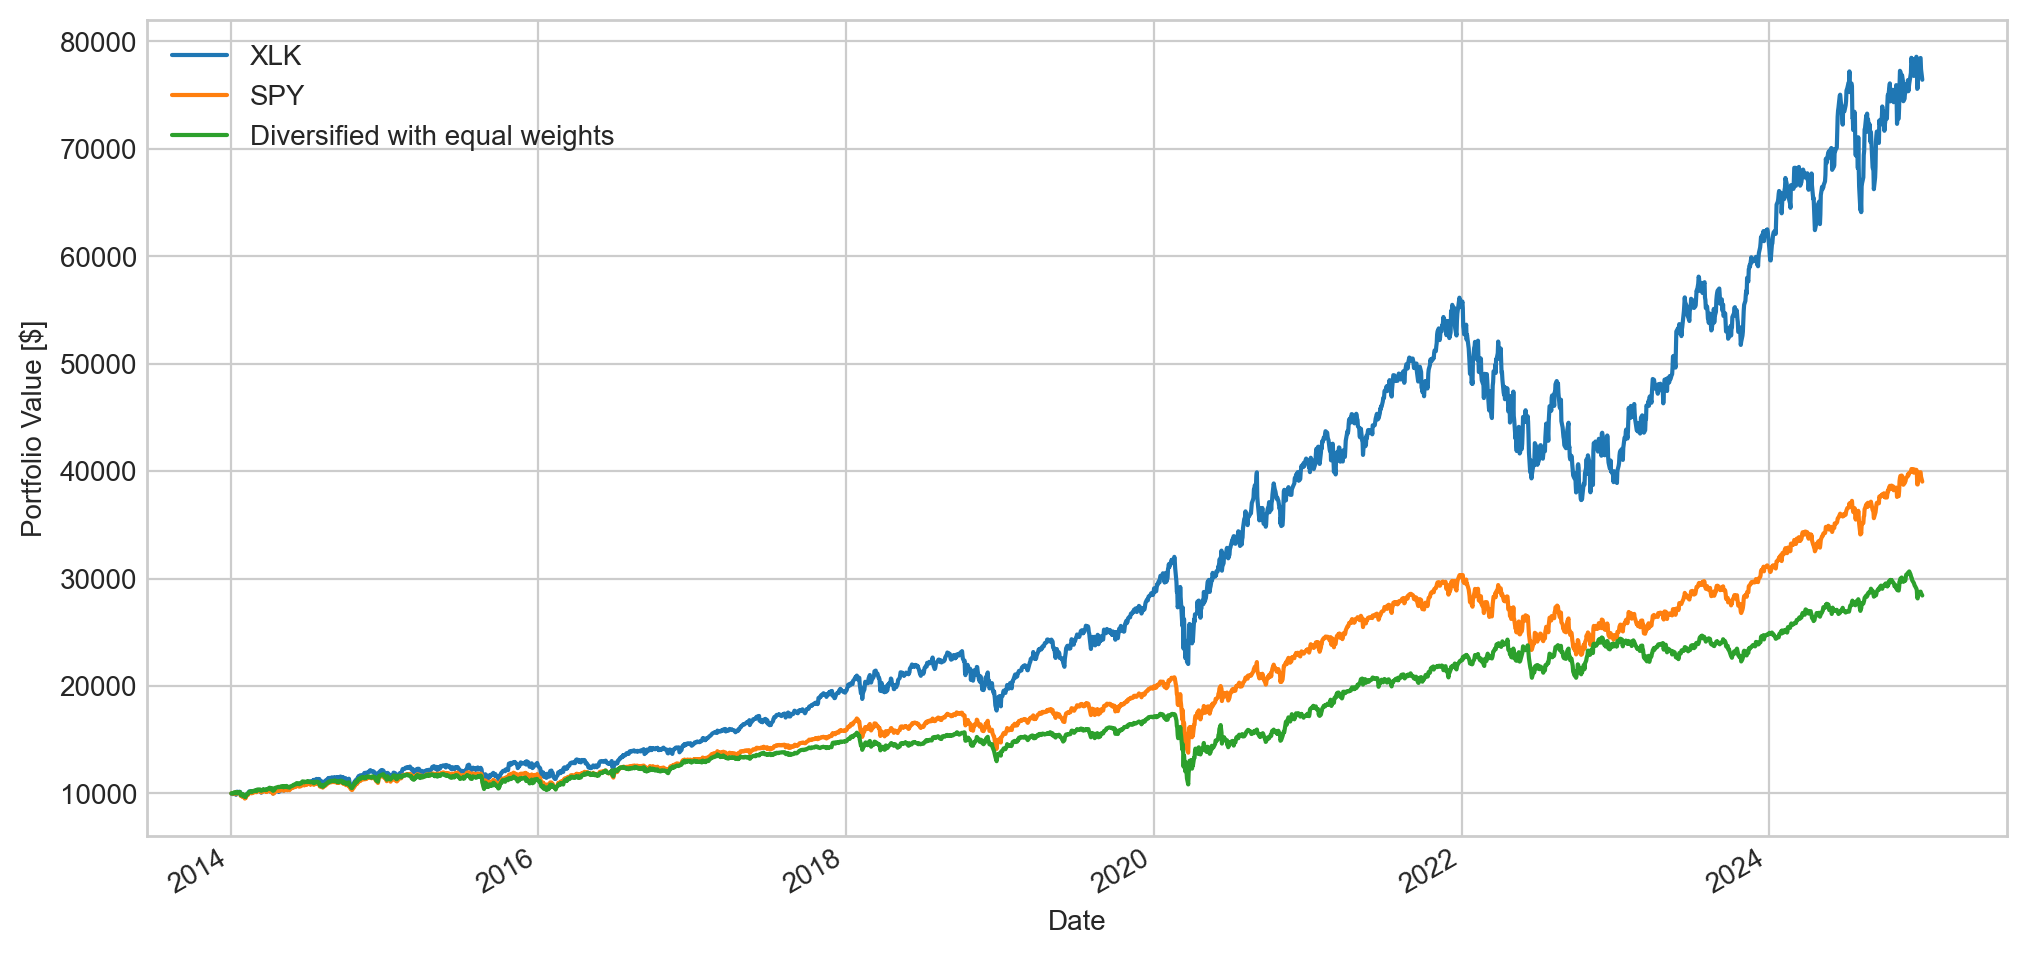

In [4]:
returns_df = prices_df.pct_change() #daily returns for each ETF
returns_df.iloc[0] = 0 #without this first row of .pct_change() would be NaN resulting in issues later
initial_capital = 10000

port_tech_returns = returns_df['XLK']
port_tech_equity = (1 + port_tech_returns).cumprod()
port_tech_equity *= initial_capital
port_tech_equity.plot()

port_bench_returns = returns_df['SPY']
port_bench_equity = (1 + port_bench_returns).cumprod()
port_bench_equity *= initial_capital
port_bench_equity.plot()

port_div_tickers = [i for i in tickers if i != 'SPY' and i != 'XLK'] #create portfolio of remaining tickers
target_weights = np.array([1/len(port_div_tickers)] * len(port_div_tickers))
port_div_equity = quarterly_rebalancing(returns_df, port_div_tickers, target_weights, initial_capital)

port_div_equity.plot(label = 'Diversified with equal weights')
plt.ylabel('Portfolio Value [$]')
plt.legend();